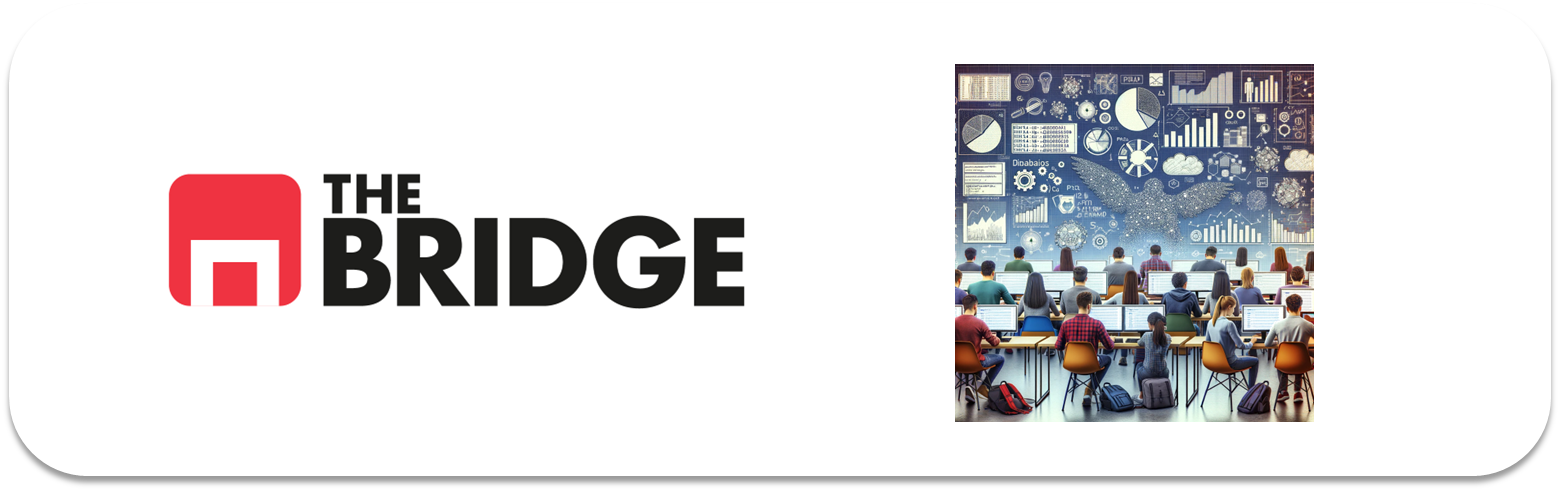

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import sys
sys.path.append('/Users/aliciamarzoa/Will/the_bridge/personal_projects/stats_help')
import dstoolbox as tlbx
import bootcampviztools as booty

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



---

### 1. Carga el dataset del Titanic. 

In [2]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
tlbx.describe_df(titanic, entries=True, print_dups=True)

Total entries in DataFrame:  891
Total duplicated entries: 107


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,int64,object,float64,int64,int64,float64,object,object,object,bool,object,object,object,bool
NUM_MISSING,0,0,0,177,0,0,0,2,0,0,0,688,2,0,0
MISSINGS (%),0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.22,0.0,0.0,0.0,77.22,0.22,0.0,0.0
UNIQUE_VALUES,2,3,2,88,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.22,0.34,0.22,9.88,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


- droppers = ['deck','alive','embarked','class']
- quite a few duplicated rows.
    - going to delete them

In [4]:
titanic.embark_town.value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

- pd.get_dummies
    - dummy_cols = ['sex','who','embark_town']

family = sibsp + parch

---
### 2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.

In [5]:
droppers = ['deck','alive','embarked']
dummy_cols = ['sex','who','embark_town']

In [6]:
# Strip and white space
for col in dummy_cols:
    titanic[col] = titanic[col].apply(lambda x: x.strip() if isinstance(x,str) else x)

# Drop unwanted columns
titanic.drop(droppers, axis=1, inplace=True)

# Drop duplicated rows
titanic.drop_duplicates(keep='first', ignore_index=True, inplace=True)

In [7]:
# Check for missing values
titanic.isna().sum()

survived         0
pclass           0
sex              0
age            104
sibsp            0
parch            0
fare             0
class            0
who              0
adult_male       0
embark_town      2
alone            0
dtype: int64

possibly do some imputation later
- ages: mean for each who class (man, woman, child)
- embark_town: mode
- Create new variable total_family = sibsp + parch

---
### 3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.

In [8]:
titanic.survived.value_counts(True)

0    0.587179
1    0.412821
Name: survived, dtype: float64

<Axes: xlabel='survived', ylabel='count'>

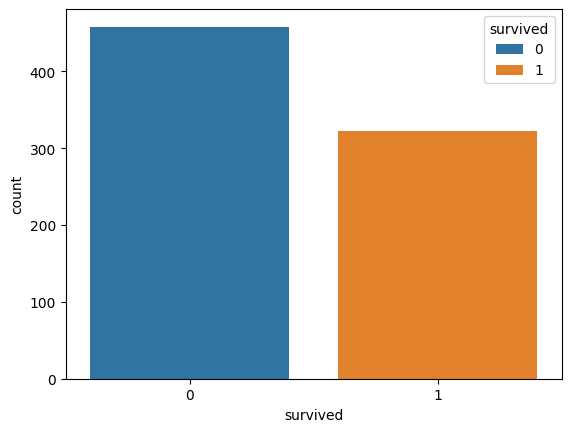

In [9]:
sns.countplot(titanic, x='survived', hue='survived')

- Class 'survived' is unbalanced which could impact the opportunity for the model to effectively learn and predict if a passenger survived or not.
- more chances to learn when a passenger is dead than alive, may put more emphasis/weight on passengers being dead.
- predicting all dead will give 61% accuracy, which although is not great, gives the impression the model is able to predict above a 50:50 chance of being correct when in reality its 'cheating'.
- Will stratify the train and test sets by 'survived'. I thought i was until i read the next step/guideline to stratify by embark_town. HOWEVER! there are 2 passengers that have missing values here.
    - Can you stratify when there are missing values?
    - Does it just split the missing value entries into train and test?
- Make sure to check accuracy score against value counts of 'survived' for 'cheating'.
- As we are focussed on if a passenger will survive (case 1) looking for a good recall score balanced by a good F1 score to ensure that model isnt overpredicting 0 (death) cases while still catching high proportion of 1 (survived) cases.

---
### 4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.

- Can't stratify if there are NaN values in that feature
    - "stratify=titanic['embark_town'])"
    - "ValueError: Input contains NaN"

- Instead of imputing at this stage i'll change NaNs to 'unknown'
- I think this will then put an unknown into each of train_set and test_set

In [10]:
# Change NaNs to 'unknown'
titanic['embark_town'].fillna('unknown', inplace=True)

# Split into train_set and test_set
train_set, test_set = train_test_split(titanic, test_size=0.2, random_state=42, stratify=titanic['embark_town'])

---
### 5. Construye las parejas X,y de train y test.

In [11]:
X_train = train_set[[col for col in train_set.columns if col != 'survived']].copy()
X_test = test_set[[col for col in train_set.columns if col != 'survived']].copy()
y_train = train_set['survived'].copy()
y_test = test_set['survived'].copy()

---
### 6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.

In [12]:
# Check distribution of 'embark_town' classes
X_train['embark_town'].value_counts()

Southampton    452
Cherbourg      124
Queenstown      46
unknown          2
Name: embark_town, dtype: int64

- surprised to get both unknowns in train_set but it makes life easier!

In [13]:
# Make the 'unknowns' NaNs again
X_train['embark_town'].replace('unknown', np.nan, inplace=True)

In [14]:
# Tried lots of other filter variations to see if i could get a modal 'embark_town' that wasn't Southampton
selected_women = X_train[(X_train['sex'] == 'female') & (X_train['age'].between(30, 40, inclusive='both'))]
et_mode = selected_women.embark_town.mode()[0]

In [15]:
# Fill NaNs with 'embark_town' mode value 'Southampton'
X_train.loc[X_train['embark_town'].isna(), 'embark_town'] = et_mode

### Imputing 'age' NaNs
- Going to use mean for each 'who' class
- mean age for man, woman, child

In [16]:
# Check classes in 'who'
X_train.who.value_counts()

man      359
woman    202
child     63
Name: who, dtype: int64

In [17]:
# Create filter variables for each 'who' class and the mean 'age'
men = X_train['who'] == 'man'
mean_men = X_train.loc[men, 'age'].mean()

women = X_train['who'] == 'woman'
mean_women = X_train.loc[women, 'age'].mean()

children = X_train['who'] == 'child'
mean_children = X_train.loc[children, 'age'].mean()

# Create a NaN filter
age_nan = X_train.age.isna()

# Apply filters to X_train and impute corresponding mean ages
X_train.loc[men & age_nan, 'age'] = mean_men
X_train.loc[women & age_nan, 'age'] = mean_women
X_train.loc[children & age_nan, 'age'] = mean_children

In [18]:
X_train.isna().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
class          0
who            0
adult_male     0
embark_town    0
alone          0
dtype: int64

---
### 7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.

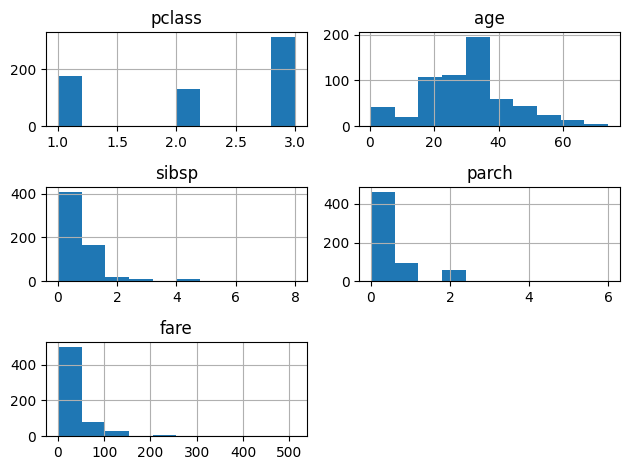

In [19]:
X_train.hist()
plt.tight_layout()

In [20]:
X_train['total_family'] = X_train['sibsp'] + X_train['parch']

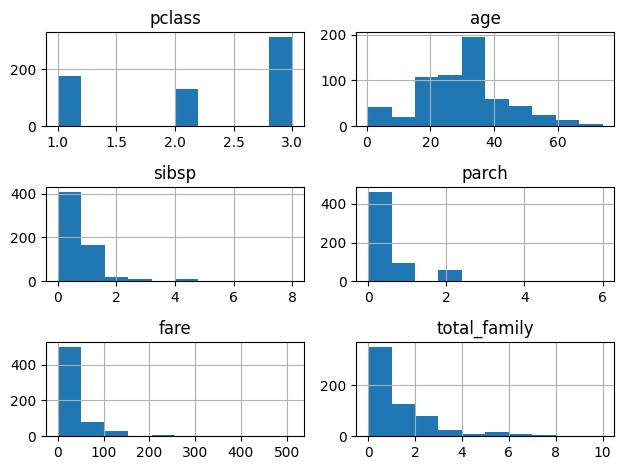

In [21]:
X_train.hist()
plt.tight_layout()

In [22]:
# Inspect 'parch'
X_train.parch.value_counts()

0    462
1     93
2     57
4      4
5      4
3      3
6      1
Name: parch, dtype: int64

In [23]:
# Inspect 'parch'
X_train.sibsp.value_counts()

0    408
1    167
2     21
3     12
4     12
5      3
8      1
Name: sibsp, dtype: int64

In [24]:
# Inspect 'total_family'
X_train.total_family.value_counts()

0     352
1     127
2      80
3      25
5      18
4       9
6       8
7       4
10      1
Name: total_family, dtype: int64

- All 3 are really categorical features.
- Best to split into class of no/yes?
- But it will be fairly unbalanced
    - Does this matter when its not the target feature?
    - Thinking it's probably better just to drop it.
- Decsision to make a feature that is family_onboard 0 = no, 1=yes


X_train['family_onboard'] = X_train['total_family'].apply(lambda x: 0 if x > 0 else 1)

- Now i see the logic written out its just creating the alone feature.
- Drop all of them.
    - if they are not alone they have a family member so either sibsp or parch

In [25]:
# Create a num_features variable for StandardScaler
num_features = ['age', 'fare']

In [26]:
X_train.columns.to_list()

['pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'class',
 'who',
 'adult_male',
 'embark_town',
 'alone',
 'total_family']

In [27]:
# Create cat_features variable for eda
cat_features = ['pclass','sex','class','who','adult_male','embark_town','alone']

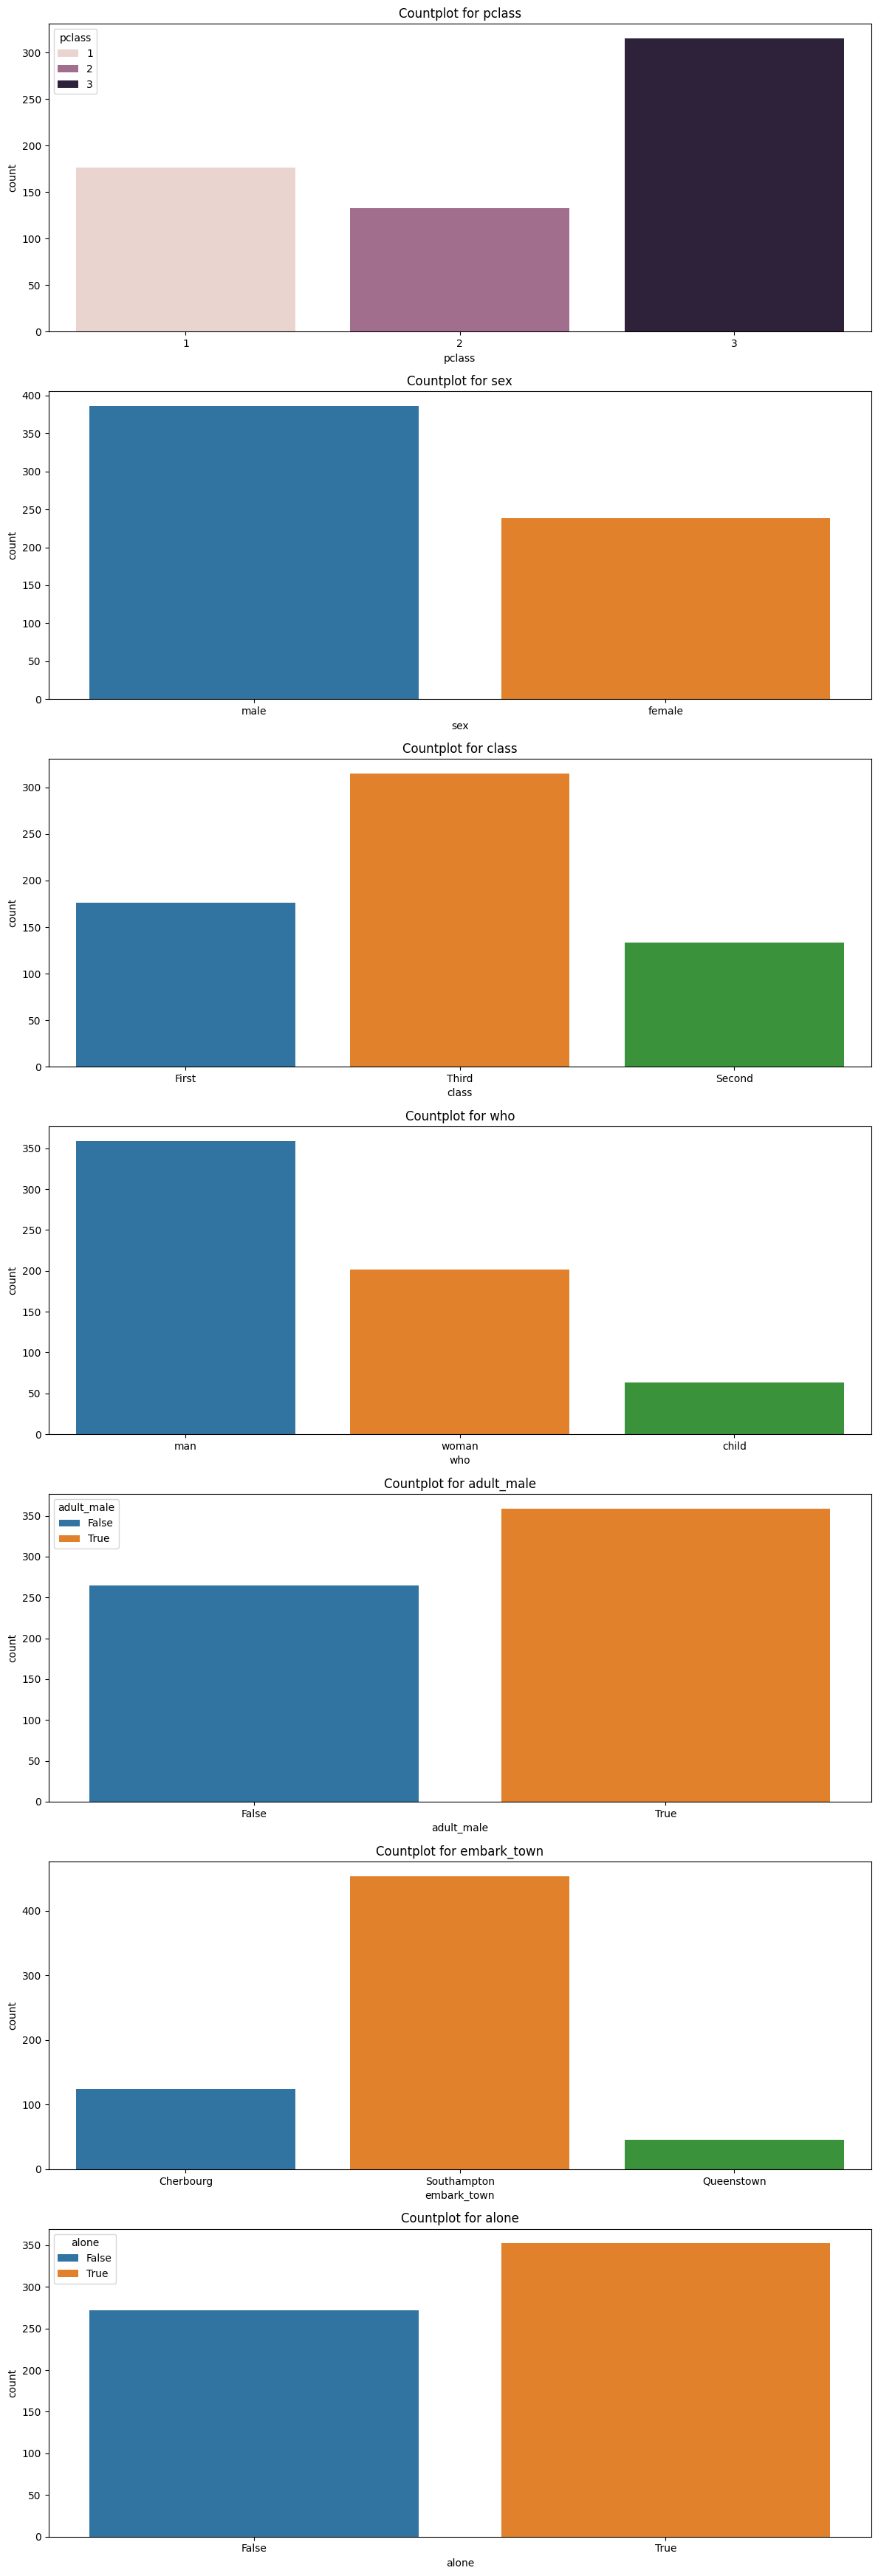

In [28]:
fig, ax = plt.subplots(len(cat_features), 1, figsize=(12, 5 * len(cat_features)))
for i, col in enumerate(cat_features):
    sns.countplot(X_train, x=col, hue=col, ax=ax[i])
    ax[i].set_title(f"Countplot for {col}")

plt.tight_layout()
plt.show()

- Drop 'class' and 'adult_male' as not really necessary. 
- Possibly just add extra noise.

In [29]:
droppers = ['class','adult_male']
X_train.drop(droppers, axis=1, inplace=True)

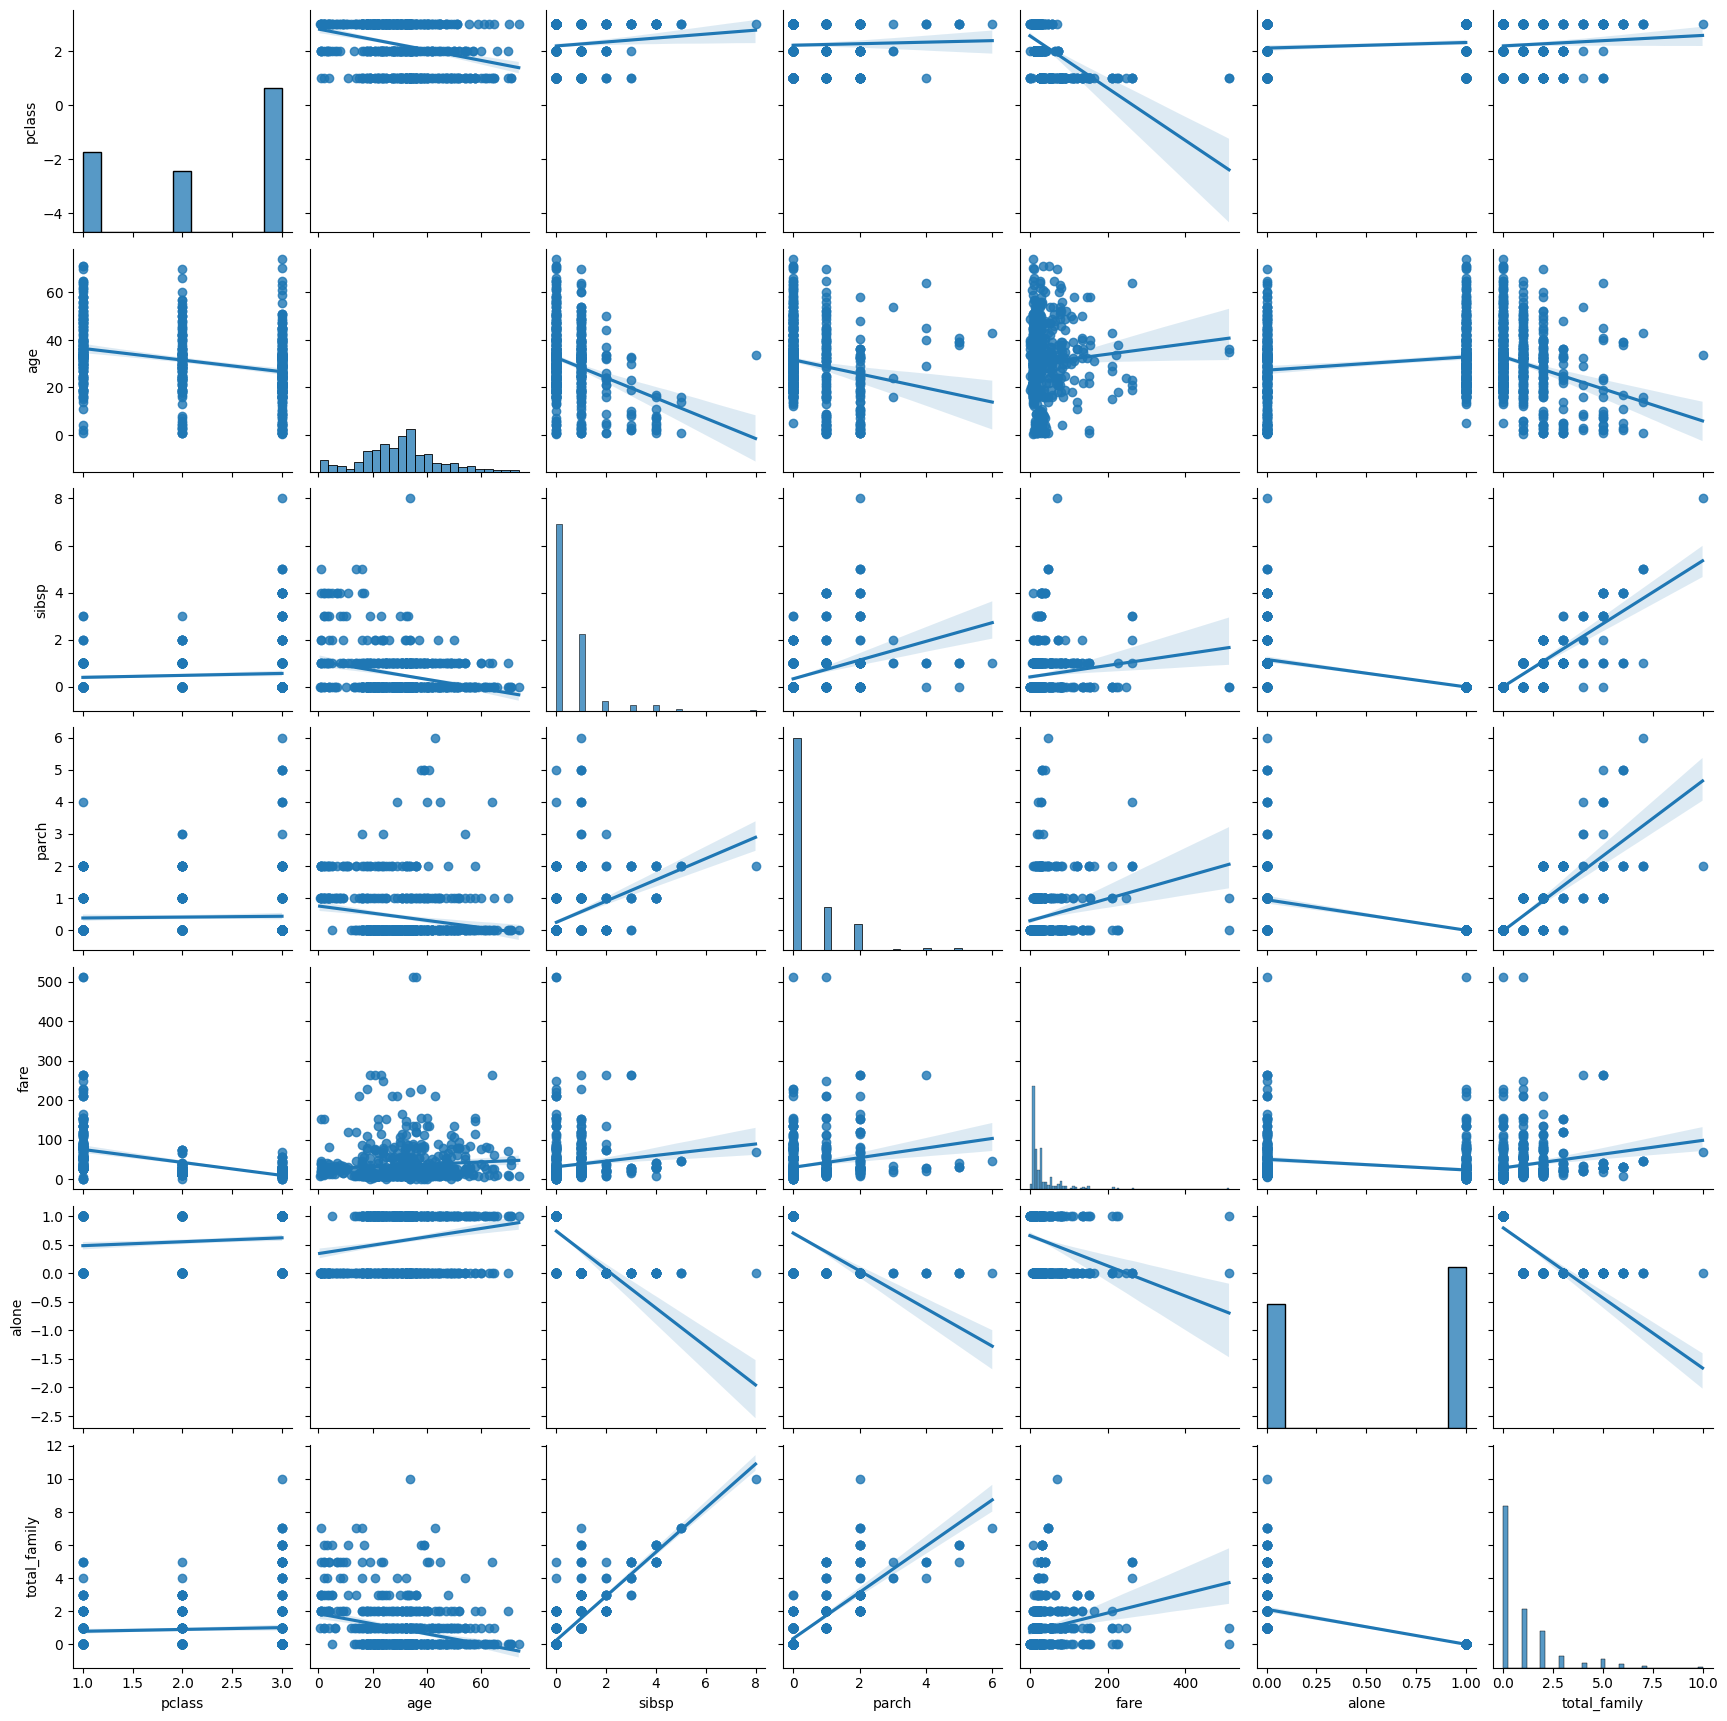

In [30]:
# See some pairplots
sns.pairplot(X_train,
             kind='reg')

In [31]:
abs(X_train.corrwith(y_train, numeric_only=True)).sort_values(ascending=False)

pclass          0.299444
fare            0.232930
alone           0.184960
age             0.112561
parch           0.085323
total_family    0.042216
sibsp           0.011186
dtype: float64

- Going to drop sibsp, parch and total_family
    - pairplots show colinearity (as epected!) which could be problematic (??Or does this only apply to linear regression models??)
    - Features also reflected in alone.
    - Consdiering alone has better correlation with target 'survived' maybe better to just have the binary feature of alone and remove some extra noise that doesnt show much correlation with the target anyway.

In [32]:
droppers = ['sibsp','parch','total_family']
X_train.drop(droppers, axis=1,inplace=True)

In [33]:
num_features

['age', 'fare']

---
### 8. Trata las variables para que funcionen lo mejor posible en el modelo.

- StandarScaler num_features
- dummy_cols = ['who','embark_town']
- Convert 'alone' to numeric binary feature
- Convert 'sex' from male/female to numeric binary feature

In [34]:
dummy_cols = ['who','embark_town']

In [35]:
# Convert 'sex' and 'alone' to numeric binary
X_train['alone'] = X_train['alone'].astype(int)
X_train['sex'] = X_train['sex'].apply(lambda x: 1 if x == 'male' else 0)

In [36]:
# One-hot encode 'who' and 'embark_town'
X_train = pd.get_dummies(X_train, columns=dummy_cols)

In [37]:
# Check X_train
X_train.head()

,pclass,sex,age,fare,alone,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
598,1,1,36.000000,512.3292,0,0,1,0,1,0,0
722,3,1,27.000000,8.6625,1,0,1,0,0,0,1
446,1,0,25.000000,151.5500,0,0,0,1,0,0,1
627,1,1,33.635179,26.5500,1,0,1,0,0,0,1
91,1,1,71.000000,34.6542,1,0,1,0,1,0,0


---
### Create a scaled version of X_train 
- i dont know if there was a better way to do this
- when i just applied StandardScaler it was like i lost all of the cat features and was only left with numeric scaled features
- splitting, scaling and concatenating was the workaround i found

In [38]:
# Make a copy for safety
X_train_scaled = X_train.copy()

In [39]:
# Split the features
X_tr_sc_num = X_train_scaled[num_features]
X_tr_sc_cat = X_train_scaled[[col for col in X_train_scaled if col not in num_features]]

In [40]:
# Scale 'fare' and 'age'
scaler = StandardScaler()
X_tr_sc_num = pd.DataFrame(scaler.fit_transform(X_train_scaled[num_features]),
                           columns = num_features)

In [41]:
# Reset indexes to be sure about concatenation
X_tr_sc_cat.reset_index(inplace=True)
X_tr_sc_num.reset_index(inplace=True)

In [42]:
# Concat back into one DataFrame
X_train_scaled = pd.concat([X_tr_sc_num, X_tr_sc_cat], axis=1)

In [43]:
# Check everything there in scaled version of X_train
X_train_scaled

,index,age,fare,index,pclass,sex,alone,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,0.407354,9.530428,598,1,1,0,0,1,0,1,0,0
1,1,-0.249421,-0.522640,722,3,1,1,0,1,0,0,0,1
2,2,-0.395371,2.329360,446,1,0,0,0,0,1,0,0,1
3,3,0.234781,-0.165610,627,1,1,1,0,1,0,0,0,1
4,4,2.961482,-0.003852,91,1,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,619,-0.431859,-0.534866,595,3,1,1,0,1,0,0,0,1
620,620,-0.979172,-0.522640,155,3,1,1,0,1,0,0,0,1
621,621,-1.052147,-0.009425,83,3,1,0,0,1,0,0,0,1
622,622,0.699255,-0.138664,331,3,1,0,0,1,0,0,0,1


---
### 9. Construye un modelo de regresión logística.

In [78]:
# Create instance of LogisiticRegression and fit to train data
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [79]:
# Create instance of LogisiticRegression and fit to scaled train data
log_reg_scaled = LogisticRegression(max_iter=10000)
log_reg_scaled.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

---
### 10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.

In [80]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['absolute coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False)

,coefficient,absolute coefficient
who_woman,1.057113,1.057113
who_child,0.367325,0.367325
embark_town_Cherbourg,0.363314,0.363314
alone,0.327932,0.327932
fare,-0.000378,0.000378
age,-0.028027,0.028027
embark_town_Queenstown,-0.108824,0.108824
embark_town_Southampton,-0.235710,0.235710
sex,-0.569599,0.569599
pclass,-1.022097,1.022097


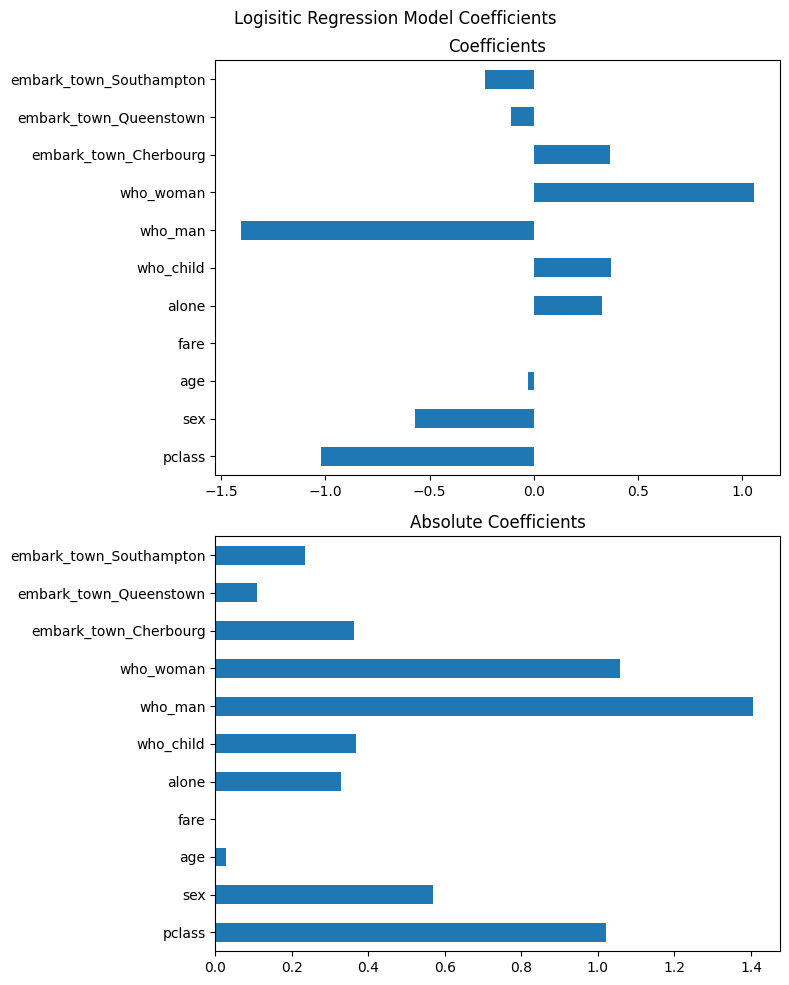

In [81]:
fig, ax = plt.subplots(2,1, figsize=(8, 10))
features['coefficient'].plot(kind='barh', legend=False, ax=ax[0])
ax[0].set_title("Coefficients")

features['absolute coefficient'].plot(kind='barh', legend=False, ax=ax[1])
ax[1].set_title("Absolute Coefficients")

plt.suptitle("Logisitic Regression Model Coefficients")

plt.tight_layout()
plt.show()


---
### 11. Procesa el dataset de Test para que puedas usarlo en la evaluación 

In [48]:
# Create filter variables for each 'who' class and the mean 'age'
men = X_test['who'] == 'man'
mean_men = X_test.loc[men, 'age'].mean()

women = X_test['who'] == 'woman'
mean_women = X_test.loc[women, 'age'].mean()

children = X_test['who'] == 'child'
mean_children = X_test.loc[children, 'age'].mean()

# Create a NaN filter
age_nan = X_test.age.isna()

# Apply filters to X_test and impute corresponding mean ages
X_test.loc[men & age_nan, 'age'] = mean_men
X_test.loc[women & age_nan, 'age'] = mean_women
X_test.loc[children & age_nan, 'age'] = mean_children

droppers = ['class','adult_male']
X_test.drop(droppers, axis=1, inplace=True)

droppers = ['sibsp','parch']
X_test.drop(droppers, axis=1,inplace=True)

# Convert 'sex' and 'alone' to numeric binary
X_test['alone'] = X_test['alone'].astype(int)
X_test['sex'] = X_test['sex'].apply(lambda x: 1 if x == 'male' else 0)

# One-hot encode 'who' and 'embark_town'
X_test = pd.get_dummies(X_test, columns=dummy_cols)

# Struggling to get this to work on X_test
"""
# Make a copy for safety
X_test_scaled = X_test.copy()

# Split the features
X_tes_sc_num = X_test_scaled[num_features]
X_tes_sc_cat = X_test_scaled[[col for col in X_test_scaled if col not in num_features]]

# Scale 'fare' and 'age' but only fit!
X_tes_sc_num = pd.DataFrame(scaler.fit(X_test_scaled[num_features]),
                           columns = num_features)

# Reset indexes to be sure about concatenation
X_tes_sc_cat.reset_index(inplace=True)
X_tes_sc_num.reset_index(inplace=True)

# Concat back into one DataFrame
X_test_scaled = pd.concat([X_tes_sc_num, X_tes_sc_cat], axis=1)
"""

"\n# Make a copy for safety\nX_test_scaled = X_test.copy()\n\n# Split the features\nX_tes_sc_num = X_test_scaled[num_features]\nX_tes_sc_cat = X_test_scaled[[col for col in X_test_scaled if col not in num_features]]\n\n# Scale 'fare' and 'age' but only fit!\nX_tes_sc_num = pd.DataFrame(scaler.fit(X_test_scaled[num_features]),\n                           columns = num_features)\n\n# Reset indexes to be sure about concatenation\nX_tes_sc_cat.reset_index(inplace=True)\nX_tes_sc_num.reset_index(inplace=True)\n\n# Concat back into one DataFrame\nX_test_scaled = pd.concat([X_tes_sc_num, X_tes_sc_cat], axis=1)\n"

---
### 12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.

In [82]:
y_pred_train = log_reg.predict(X_train)
y_pred_train_sc = log_reg_scaled.predict(X_train_scaled)

y_pred_test = log_reg.predict(X_test)

In [83]:
from sklearn.metrics import accuracy_score

acc_train = round(accuracy_score(y_pred_train, y_train), 5)
acc_train_sc = round(accuracy_score(y_pred_train_sc, y_train), 5)
acc_test = round(accuracy_score(y_pred_test, y_test), 5)

print(f"Train Accuracy Score: {acc_train}")
print(f"Train Scaled Accuracy Score: {acc_train_sc}")
print(f"Test Accuracy: {acc_test}")

Train Accuracy Score: 0.80609
Train Scaled Accuracy Score: 0.80288
Test Accuracy: 0.71795


In [84]:
# Create tabular confusion matrix for train data
conf_mat_train = pd.DataFrame(confusion_matrix(y_train, y_pred_train),
                        index=[f'Actual {i}' for i in log_reg.classes_],
                        columns=[f'Prediction {i}' for i in log_reg.classes_])
conf_mat_train

,Prediction 0,Prediction 1
Actual 0,304,59
Actual 1,62,199


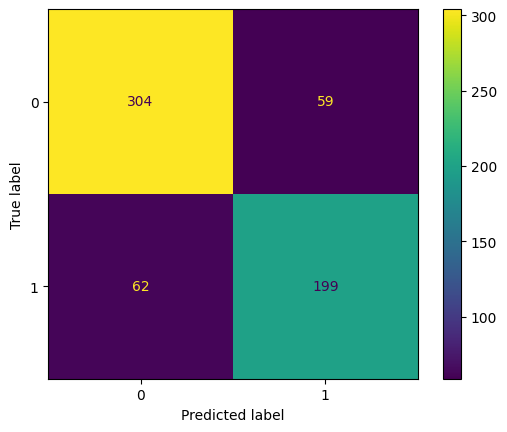

In [53]:
# Abs confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

<Axes: >

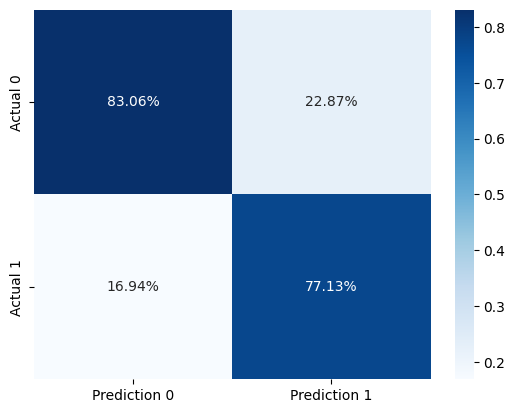

In [85]:
# Percentage confusion matrix
sns.heatmap(conf_mat_train/np.sum(conf_mat_train), annot=True,
            fmt='.2%', cmap='Blues')

In [86]:
# Calssification Report
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       363
           1       0.77      0.76      0.77       261

    accuracy                           0.81       624
   macro avg       0.80      0.80      0.80       624
weighted avg       0.81      0.81      0.81       624



---
### Test Data

In [87]:
# Create tabular confusion matrix for test data
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_pred_test),
                        index=[f'Actual {i}' for i in log_reg.classes_],
                        columns=[f'Prediction {i}' for i in log_reg.classes_])
conf_mat_test

,Prediction 0,Prediction 1
Actual 0,74,21
Actual 1,23,38


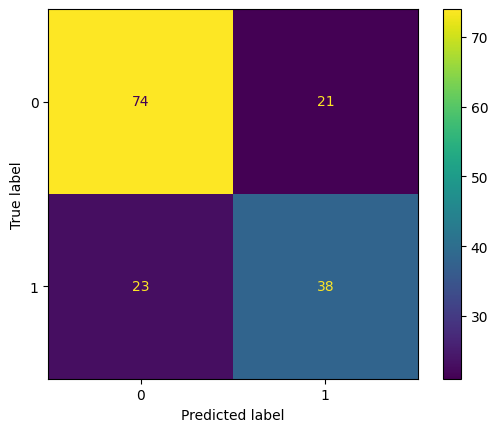

In [58]:
# Abs confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

<Axes: >

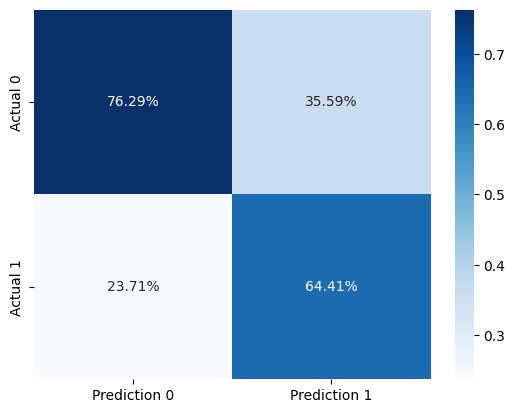

In [88]:
# Percentage confusion matrix
sns.heatmap(conf_mat_test/np.sum(conf_mat_test), annot=True,
            fmt='.2%', cmap='Blues')

In [89]:
# Classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        95
           1       0.64      0.62      0.63        61

    accuracy                           0.72       156
   macro avg       0.70      0.70      0.70       156
weighted avg       0.72      0.72      0.72       156



---
### 13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.

---
### 14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report. 

In [72]:
X_test2 = X_test.copy()
X_test2['survived'] = y_test.copy()
X_train2 = X_train.copy()
X_train2['survived'] = y_train.copy()

y_train2 = X_train['pclass']
y_test2 = X_test['pclass']

X_train2.drop('pclass', axis=1, inplace=True)
X_test2.drop('pclass', axis=1, inplace=True)

In [77]:
log_reg2 = LogisticRegression(max_iter=10000)
log_reg2.fit(X_train2, y_train2)

LogisticRegression(max_iter=10000)

In [90]:
y_pred_train2 = log_reg2.predict(X_train2)
y_pred_test2 = log_reg2.predict(X_test2)

In [91]:
print(classification_report(y_train2, y_pred_train2))

              precision    recall  f1-score   support

           1       0.89      0.91      0.90       176
           2       0.61      0.32      0.42       133
           3       0.78      0.92      0.84       315

    accuracy                           0.79       624
   macro avg       0.76      0.72      0.72       624
weighted avg       0.77      0.79      0.77       624



In [92]:
print(classification_report(y_test2, y_pred_test2))

              precision    recall  f1-score   support

           1       0.88      0.97      0.92        36
           2       0.50      0.13      0.21        31
           3       0.78      0.94      0.85        89

    accuracy                           0.79       156
   macro avg       0.72      0.68      0.66       156
weighted avg       0.75      0.79      0.74       156

